# pycaret을 이용한 가스공급량 예측
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'
* 특성
    * 'month', '시간'으로 기온 예측
    * 기온, 기압, 습도 순서로 예측
    * 각 특성 예측 마다 앞에서 예측한 특성 활용
    * 공급량 예측(6개) : 'month', '시간', '구분', '기온', '기압', '습도'
* 공급량 log적용
* 2개 모델('lightgbm', 'catboost') 예측 평균
* lgbm만 튜닝

In [1]:
# 제출 파일명 : sub21_pycaret09.csv
# 제출 점수 : 0.1072981748(2021-12-01 16:20:56)

## 데이터 가져오기
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'

In [2]:
from pycaret.regression import *

In [3]:
import time
import datetime
import pandas as pd

### 2013-2018년 가스공급량과 기온 자료

In [4]:
total = pd.read_csv('../2013-2018년_가스공급량_기온_습도_기압01.csv')
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


### 2019년 데이터

In [5]:
test2019 = pd.read_csv('../data/test.csv')
test2019.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [6]:
test2019[['연월일', '시간', '구분']] = test2019['일자|시간|구분'].str.split(' ').tolist()
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,A
1,2019-01-01 02 A,2019-01-01,02,A
2,2019-01-01 03 A,2019-01-01,03,A
3,2019-01-01 04 A,2019-01-01,04,A
4,2019-01-01 05 A,2019-01-01,05,A


In [7]:
# 구분 열을 숫자로 바꾸기
d_map = {}
for i, d in enumerate(test2019['구분'].unique()):
    d_map[d] = i
test2019['구분'] = test2019['구분'].map(d_map)
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,0
1,2019-01-01 02 A,2019-01-01,02,0
2,2019-01-01 03 A,2019-01-01,03,0
3,2019-01-01 04 A,2019-01-01,04,0
4,2019-01-01 05 A,2019-01-01,05,0


In [8]:
# 연월일 열은 object형이므로 년, 월, 일로 나눈다.
test2019['연월일'] = pd.to_datetime(test2019['연월일'])
test2019['year'] = test2019['연월일'].dt.year
test2019['month'] = test2019['연월일'].dt.month
test2019['day'] = test2019['연월일'].dt.day
test2019['weekday'] = test2019['연월일'].dt.weekday
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


### 상관계수 확인

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

import platform
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

<AxesSubplot:>

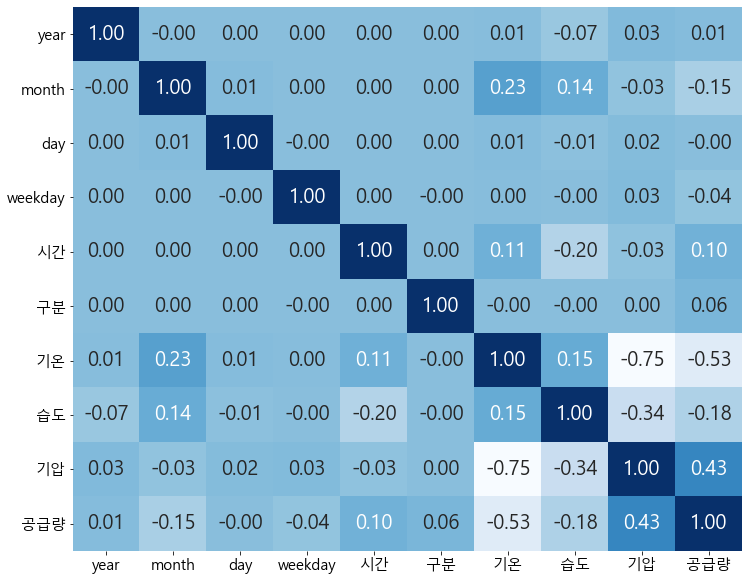

In [10]:
plt.figure(figsize=(12,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(total[['year','month', 'day', 'weekday', '시간', '구분', '기온','습도','기압','공급량']].corr(), cmap='Blues', annot=True, fmt='.2f', cbar=False, annot_kws={"size": 20})

(array([ 1631., 12285., 32193., 47222., 53382., 56679., 58002., 46487.,
        38262., 21945.]),
 array([  7. ,  16.3,  25.6,  34.9,  44.2,  53.5,  62.8,  72.1,  81.4,
         90.7, 100. ]),
 <BarContainer object of 10 artists>)

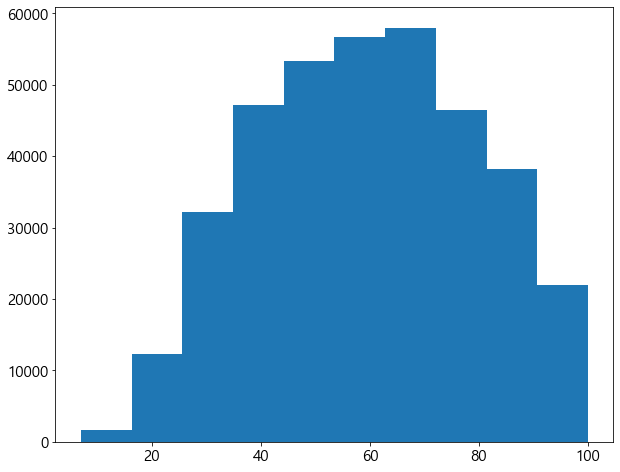

In [11]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='습도', data=total)

(array([  420.,  1414.,  9597., 43568., 77329., 70378., 79037., 60480.,
        23170.,  2695.]),
 array([ 976.5 ,  981.68,  986.86,  992.04,  997.22, 1002.4 , 1007.58,
        1012.76, 1017.94, 1023.12, 1028.3 ]),
 <BarContainer object of 10 artists>)

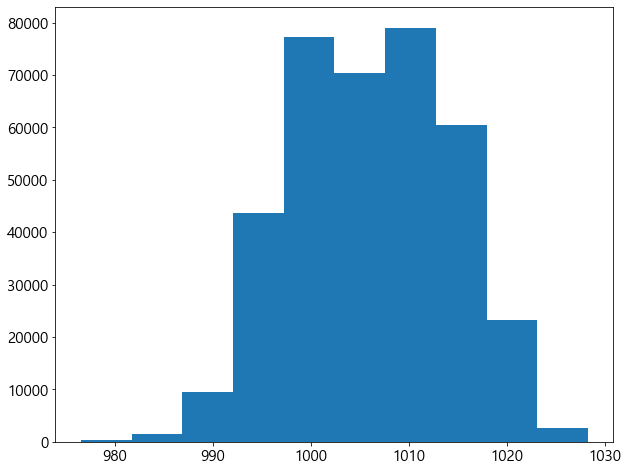

In [12]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기압', data=total)

(array([ 1708., 12180., 36729., 52906., 48832., 49889., 64701., 73080.,
        26040.,  2023.]),
 array([-18.  , -12.26,  -6.52,  -0.78,   4.96,  10.7 ,  16.44,  22.18,
         27.92,  33.66,  39.4 ]),
 <BarContainer object of 10 artists>)

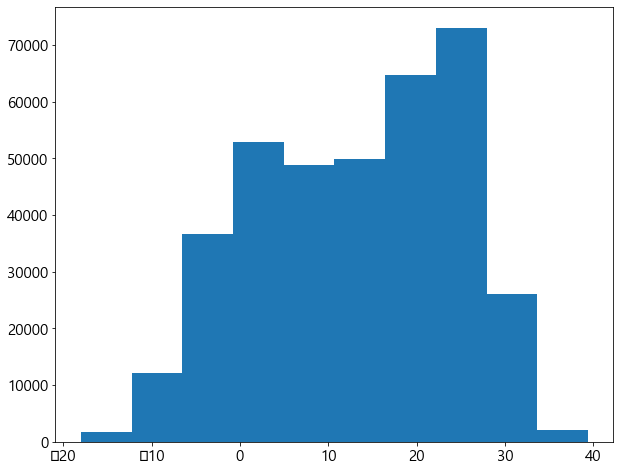

In [13]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기온', data=total)

(array([2.56069e+05, 7.60110e+04, 2.76280e+04, 7.43600e+03, 8.86000e+02,
        5.30000e+01, 2.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([1.37800000e+00, 1.16060190e+03, 2.31982580e+03, 3.47904970e+03,
        4.63827360e+03, 5.79749750e+03, 6.95672140e+03, 8.11594530e+03,
        9.27516920e+03, 1.04343931e+04, 1.15936170e+04]),
 <BarContainer object of 10 artists>)

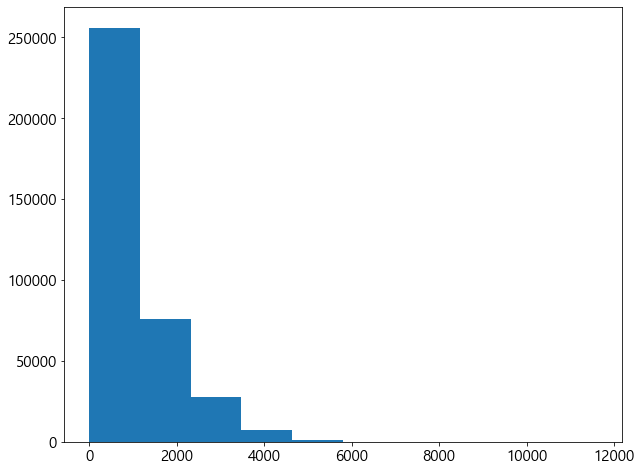

In [14]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='공급량', data=total)

<Figure size 864x576 with 0 Axes>

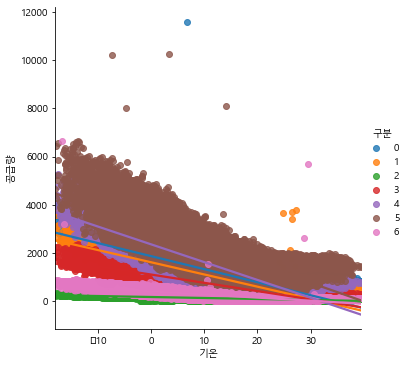

In [15]:
plt.figure(figsize=(12,8))
sns.lmplot(x='기온', y='공급량', hue='구분', data=total)

## 2019년 기온 훈련하기

In [16]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


In [17]:
# 학습 특성 : 'month', '시간'
# 타겟 특성 : '기온'

exp = setup(total, target='기온',
 ignore_features=['공급량', 'year', 'day', 'weekday', '구분', '습도', '기압'],
 silent=True, fold=7, fold_shuffle=True, verbose=False)

In [18]:
# 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [19]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.0200,15.2478,3.9048,0.8794,0.5134,0.7822
1,3.0062,15.0137,3.8747,0.8813,0.5116,0.7744
2,3.0161,15.0251,3.8762,0.8827,0.5157,0.7917
3,3.0101,15.0053,3.8737,0.8824,0.5123,0.7827
4,3.0107,15.0434,3.8786,0.8808,0.5162,0.8149
5,3.0028,15.0346,3.8774,0.8816,0.5166,0.8337
6,3.0400,15.3042,3.9121,0.8800,0.5130,0.8151
Mean,3.0151,15.0963,3.8854,0.8812,0.5141,0.7992
SD,0.0115,0.1152,0.0148,0.0011,0.0018,0.0204


0:00:14


In [20]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.0202,15.2495,3.9051,0.8794,0.5135,0.7825
1,3.0062,15.0129,3.8747,0.8813,0.5121,0.7745
2,3.0162,15.0261,3.8764,0.8827,0.5158,0.7919
3,3.0099,15.0035,3.8734,0.8824,0.5128,0.7827
4,3.0108,15.0449,3.8788,0.8808,0.5164,0.8149
5,3.0029,15.0356,3.8776,0.8816,0.5165,0.8340
6,3.0399,15.3033,3.9119,0.8800,0.5134,0.8153
Mean,3.0152,15.0966,3.8854,0.8812,0.5144,0.7994
SD,0.0114,0.1154,0.0148,0.0011,0.0017,0.0205


0:02:40


In [21]:
# lgbm 모델 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.1514,16.3082,4.0383,0.8710,0.5540,0.7818
1,3.1327,16.0385,4.0048,0.8732,0.5495,0.7772
2,3.1424,16.1106,4.0138,0.8742,0.5471,0.7913
3,3.1463,16.1590,4.0198,0.8734,0.5525,0.7782
4,3.1290,16.0356,4.0045,0.8730,0.5470,0.8009
5,3.1346,16.0863,4.0108,0.8734,0.5458,0.8344
6,3.1668,16.3836,4.0477,0.8716,0.5513,0.8122
Mean,3.1433,16.1602,4.0200,0.8728,0.5496,0.7966
SD,0.0121,0.1254,0.0156,0.0010,0.0029,0.0195


0:01:48


In [22]:
# lgbm 훈련 완료(모든 샘플에 대한 재훈련)
start = time.time()

temp_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:05


In [23]:
# cat 훈련 완료(모든 샘플에 대한 재훈련)
start = time.time()

temp_prediction_cat = finalize_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:03:02


### 2019년 기온 예측

In [24]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


In [25]:
# lgbm 기온 예측
start = time.time()

df = test2019[['month', '시간']]
temp2019_pred_lgbm = predict_model(temp_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [26]:
# cat 기온 예측
start = time.time()

df = test2019[['month', '시간']]
temp2019_pred_cat = predict_model(temp_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [27]:
temp2019_pred_lgbm.head()

,month,시간,Label
0,1,01,-1.726682
1,1,02,-1.991384
2,1,03,-2.139104
3,1,04,-2.364445
4,1,05,-2.587039


In [28]:
temp2019_pred_cat.head()

,month,시간,Label
0,1,01,-3.577097
1,1,02,-3.860767
2,1,03,-4.110426
3,1,04,-4.348725
4,1,05,-4.574723


In [29]:
# 두 모델 기온 예측 평균
temp2019_pred = (temp2019_pred_lgbm['Label'] + temp2019_pred_cat['Label']) / 2

In [30]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


In [31]:
# 2019년 예측 기온 열 추가
test2019['기온'] = temp2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-2.651890
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-2.926076
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-3.124765
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-3.356585
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-3.580881


## 2019년 기압 훈련

In [32]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


In [33]:
# 학습 특성 : 'month', '시간', '기온'
# 타겟 특성 : '기압'

exp = setup(total, target='기압', ignore_features=['공급량', 'year', 'weekday', 'day', '습도', '구분'], 
            silent=True, fold=7, fold_shuffle=True, verbose=False)

In [34]:
# # 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [35]:
# lightgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.4388,19.8242,4.4524,0.6957,0.0044,0.0034
1,3.4674,19.9447,4.4659,0.6925,0.0044,0.0034
2,3.4583,20.0483,4.4775,0.6936,0.0044,0.0034
3,3.4985,20.4291,4.5199,0.6866,0.0045,0.0035
4,3.4734,20.1239,4.4860,0.6907,0.0045,0.0035
5,3.4502,19.8014,4.4499,0.6945,0.0044,0.0034
6,3.4662,19.8986,4.4608,0.6933,0.0044,0.0034
Mean,3.4647,20.0100,4.4732,0.6924,0.0044,0.0034
SD,0.0175,0.2017,0.0225,0.0028,0.0000,0.0000


0:00:06


In [36]:
# catboost 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.3800,19.1549,4.3766,0.7060,0.0043,0.0034
1,3.4088,19.2802,4.3909,0.7027,0.0044,0.0034
2,3.4005,19.3977,4.4043,0.7035,0.0044,0.0034
3,3.4410,19.7591,4.4451,0.6968,0.0044,0.0034
4,3.4129,19.4227,4.4071,0.7015,0.0044,0.0034
5,3.3905,19.1550,4.3766,0.7045,0.0043,0.0034
6,3.4158,19.3234,4.3958,0.7022,0.0044,0.0034
Mean,3.4071,19.3562,4.3995,0.7025,0.0044,0.0034
SD,0.0182,0.1914,0.0217,0.0027,0.0000,0.0000


0:02:35


In [37]:
# lgbm 모델 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.2212,17.4404,4.1762,0.7323,0.0042,0.0032
1,3.2537,17.5994,4.1952,0.7286,0.0042,0.0032
2,3.2503,17.7554,4.2137,0.7286,0.0042,0.0032
3,3.2768,17.9386,4.2354,0.7248,0.0042,0.0033
4,3.2458,17.6005,4.1953,0.7295,0.0042,0.0032
5,3.2407,17.4226,4.1740,0.7312,0.0041,0.0032
6,3.2686,17.6992,4.2070,0.7272,0.0042,0.0033
Mean,3.2510,17.6366,4.1995,0.7289,0.0042,0.0032
SD,0.0169,0.1674,0.0199,0.0023,0.0000,0.0000


0:01:41


In [38]:
# lgbm 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

pressure_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:15


In [39]:
# cat 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

pressure_prediction_cat = finalize_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:03:09


### 2019년 기압 예측

In [40]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-2.651890
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-2.926076
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-3.124765
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-3.356585
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-3.580881


In [41]:
# lgbm 모델 기압 예측
start = time.time()

df = test2019[['month', '시간', '기온']]
pressure2019_pred_lgbm = predict_model(pressure_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [42]:
# cat 모델 기압 예측
start = time.time()

df = test2019[['month', '시간', '기온']]
pressure2019_pred_cat = predict_model(pressure_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [43]:
pressure2019_pred_lgbm.head()

,month,시간,기온,Label
0,1,01,-2.651890,1016.729890
1,1,02,-2.926076,1012.905349
2,1,03,-3.124765,1013.350239
3,1,04,-3.356585,1011.111312
4,1,05,-3.580881,1013.992254


In [44]:
pressure2019_pred_cat.head()

,month,시간,기온,Label
0,1,01,-2.651890,1014.737724
1,1,02,-2.926076,1014.027377
2,1,03,-3.124765,1014.864748
3,1,04,-3.356585,1014.617911
4,1,05,-3.580881,1014.600629


In [45]:
# 두 모델 기압 예측 평균
pressure2019_pred = (pressure2019_pred_lgbm['Label'] + pressure2019_pred_cat['Label']) / 2

In [46]:
pressure2019_pred.head()

0    1015.733807
1    1013.466363
2    1014.107494
3    1012.864611
4    1014.296442
Name: Label, dtype: float64

In [47]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-2.651890
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-2.926076
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-3.124765
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-3.356585
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-3.580881


In [48]:
# 2019년 예측 기압 열 추가
test2019['기압'] = pressure2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-2.651890,1015.733807
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-2.926076,1013.466363
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-3.124765,1014.107494
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-3.356585,1012.864611
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-3.580881,1014.296442


## 2019년 습도(Humidity) 훈련

In [49]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


In [50]:
# 학습 특성 : 'month', '시간', '기온', '기압'
# 타겟 특성 : '습도'

# 적용 특성 설정
exp = setup(total, target='습도', ignore_features=['공급량', 'year', 'day', 'weekday', '구분'],
 fold=7, fold_shuffle=True, silent=True)

,Description,Value
0,session_id,3470
1,Target,습도
2,Original Data,"(368088, 10)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 15)"


In [51]:
# # 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [52]:
# lightgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10.5843,180.3393,13.4290,0.5472,0.2586,0.2187
1,10.4632,176.2422,13.2756,0.5578,0.2548,0.2151
2,10.4645,176.1372,13.2717,0.5558,0.2533,0.2135
3,10.4686,176.6292,13.2902,0.5539,0.2534,0.2135
4,10.5506,178.8635,13.3740,0.5502,0.2564,0.2167
5,10.5041,177.8354,13.3355,0.5550,0.2553,0.2152
6,10.4557,175.7776,13.2581,0.5540,0.2530,0.2132
Mean,10.4987,177.4035,13.3192,0.5534,0.2550,0.2152
SD,0.0466,1.5644,0.0586,0.0033,0.0019,0.0019


0:00:06


In [53]:
# catboost 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10.0236,164.3441,12.8197,0.5873,0.2482,0.2070
1,9.9073,161.3298,12.7016,0.5952,0.2452,0.2038
2,9.8978,161.0046,12.6888,0.5940,0.2433,0.2018
3,9.9162,161.7882,12.7196,0.5914,0.2439,0.2022
4,10.0110,164.1568,12.8124,0.5872,0.2470,0.2057
5,9.9253,162.1249,12.7328,0.5943,0.2452,0.2035
6,9.8863,160.0432,12.6508,0.5939,0.2431,0.2017
Mean,9.9382,162.1131,12.7322,0.5919,0.2451,0.2037
SD,0.0515,1.4826,0.0582,0.0031,0.0018,0.0019


0:03:03


In [54]:
# lgbm 모델 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.5102,120.2790,10.9672,0.6980,0.2150,0.1750
1,8.4193,118.1390,10.8692,0.7036,0.2125,0.1724
2,8.4266,118.0772,10.8663,0.7022,0.2103,0.1709
3,8.4443,118.6781,10.8939,0.7003,0.2110,0.1713
4,8.5240,120.8312,10.9923,0.6961,0.2142,0.1743
5,8.4437,118.8229,10.9006,0.7027,0.2127,0.1725
6,8.4462,118.9410,10.9060,0.6982,0.2121,0.1720
Mean,8.4592,119.1098,10.9137,0.7002,0.2125,0.1726
SD,0.0379,0.9737,0.0445,0.0026,0.0015,0.0014


0:03:33


In [55]:
# lgbm 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

humidity_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:18


In [56]:
# cat 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

humidity_prediction_cat = finalize_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:03:23


### 2019년 습도 예측

In [57]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-2.651890,1015.733807
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-2.926076,1013.466363
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-3.124765,1014.107494
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-3.356585,1012.864611
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-3.580881,1014.296442


In [58]:
# lgbm 모델 습도 예측
start = time.time()

df = test2019[['month', '시간', '기온', '기압']]
humidity2019_pred_lgbm = predict_model(humidity_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [59]:
# cat 모델 습도 예측
start = time.time()

df = test2019[['month', '시간', '기온', '기압']]
humidity2019_pred_cat = predict_model(humidity_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [60]:
humidity2019_pred_lgbm.head()

,month,시간,기온,기압,Label
0,1,01,-2.651890,1015.733807,56.015674
1,1,02,-2.926076,1013.466363,56.777028
2,1,03,-3.124765,1014.107494,57.809387
3,1,04,-3.356585,1012.864611,58.297270
4,1,05,-3.580881,1014.296442,58.631489


In [61]:
humidity2019_pred_cat.head()

,month,시간,기온,기압,Label
0,1,01,-2.651890,1015.733807,57.725665
1,1,02,-2.926076,1013.466363,60.697395
2,1,03,-3.124765,1014.107494,61.630041
3,1,04,-3.356585,1012.864611,58.100945
4,1,05,-3.580881,1014.296442,60.766342


In [62]:
# 두 모델 습도 예측 평균
humidity2019_pred = (humidity2019_pred_lgbm['Label'] + humidity2019_pred_cat['Label']) / 2

In [63]:
humidity2019_pred.head()

0    56.870670
1    58.737212
2    59.719714
3    58.199107
4    59.698915
Name: Label, dtype: float64

In [64]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-2.651890,1015.733807
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-2.926076,1013.466363
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-3.124765,1014.107494
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-3.356585,1012.864611
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-3.580881,1014.296442


In [65]:
# 2019년 예측 습도 열 추가
test2019['습도'] = humidity2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압,습도
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-2.651890,1015.733807,56.870670
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-2.926076,1013.466363,58.737212
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-3.124765,1014.107494,59.719714
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-3.356585,1012.864611,58.199107
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-3.580881,1014.296442,59.698915


## 2019년 가스 공급량 훈련

In [66]:
import numpy as np

In [67]:
total['log_공급량'] = np.log1p(total['공급량'])
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,log_공급량
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,7.823297
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0,7.682525
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0,5.425734
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0,7.269280
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0,8.093718


In [68]:
# 학습 특성 : 'month', '시간', '구분', '기온', '기압', '습도'
exp = setup(total, target='log_공급량', ignore_features=['year', 'weekday', '공급량', 'day'],
            silent=True, fold=7, fold_shuffle=True)

,Description,Value
0,session_id,8078
1,Target,log_공급량
2,Original Data,"(368088, 11)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 23)"


In [69]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1436,0.0900,0.3000,0.9361,0.0793,0.0414
1,0.1455,0.1027,0.3205,0.9290,0.0865,0.0455
2,0.1417,0.0894,0.2990,0.9374,0.0805,0.0422
3,0.1438,0.0961,0.3101,0.9329,0.0837,0.0439
4,0.1429,0.0935,0.3058,0.9348,0.0818,0.0427
5,0.1438,0.0950,0.3081,0.9331,0.0829,0.0436
6,0.1455,0.1025,0.3201,0.9300,0.0875,0.0463
Mean,0.1438,0.0956,0.3091,0.9333,0.0832,0.0437
SD,0.0013,0.0050,0.0080,0.0029,0.0028,0.0016


0:00:08


In [70]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1324,0.0814,0.2853,0.9422,0.0758,0.0381
1,0.1351,0.0944,0.3072,0.9348,0.0833,0.0423
2,0.1317,0.0825,0.2873,0.9422,0.0775,0.0392
3,0.1333,0.0882,0.2969,0.9384,0.0807,0.0409
4,0.1322,0.0849,0.2915,0.9408,0.0784,0.0395
5,0.1340,0.0888,0.2980,0.9375,0.0804,0.0408
6,0.1345,0.0920,0.3033,0.9371,0.0835,0.0427
Mean,0.1333,0.0875,0.2956,0.9390,0.0800,0.0405
SD,0.0012,0.0044,0.0075,0.0026,0.0027,0.0016


0:03:01


In [71]:
# lgbm 모델 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1328,0.0823,0.2869,0.9415,0.0759,0.0380
1,0.1371,0.0984,0.3137,0.9320,0.0845,0.0428
2,0.1325,0.0834,0.2888,0.9416,0.0775,0.0391
3,0.1351,0.0909,0.3015,0.9365,0.0814,0.0412
4,0.1340,0.0884,0.2972,0.9384,0.0796,0.0402
5,0.1366,0.0926,0.3044,0.9348,0.0817,0.0416
6,0.1355,0.0945,0.3074,0.9354,0.0840,0.0428
Mean,0.1348,0.0901,0.3000,0.9372,0.0807,0.0408
SD,0.0017,0.0054,0.0090,0.0033,0.0030,0.0017


0:01:48


In [72]:
# lgbm 훈련 완료
start = time.time()

gas_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:21


In [73]:
# cat 훈련 완료
start = time.time()

gas_prediction_cat = finalize_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:04:18


### 2019년 가스 공급량 예측

In [74]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압,습도
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-2.651890,1015.733807,56.870670
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-2.926076,1013.466363,58.737212
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-3.124765,1014.107494,59.719714
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-3.356585,1012.864611,58.199107
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-3.580881,1014.296442,59.698915


In [75]:
# lgbm log_공급량 예측
start = time.time()

df = test2019[['month', '시간', '구분', '기온', '기압', '습도']]
log_gas2019_pred_lgbm = predict_model(gas_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [76]:
# cat log_공급량 예측
start = time.time()

df = test2019[['month', '시간', '구분', '기온', '기압', '습도']]
log_gas2019_pred_cat = predict_model(gas_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [77]:
log_gas2019_pred_lgbm.head()

,month,시간,구분,기온,기압,습도,Label
0,1,01,0,-2.651890,1015.733807,56.870670,7.576973
1,1,02,0,-2.926076,1013.466363,58.737212,7.398896
2,1,03,0,-3.124765,1014.107494,59.719714,7.356825
3,1,04,0,-3.356585,1012.864611,58.199107,7.368935
4,1,05,0,-3.580881,1014.296442,59.698915,7.510077


In [78]:
log_gas2019_pred_cat.head()

,month,시간,구분,기온,기압,습도,Label
0,1,01,0,-2.651890,1015.733807,56.870670,7.589821
1,1,02,0,-2.926076,1013.466363,58.737212,7.449567
2,1,03,0,-3.124765,1014.107494,59.719714,7.359461
3,1,04,0,-3.356585,1012.864611,58.199107,7.395549
4,1,05,0,-3.580881,1014.296442,59.698915,7.484493


#### log_공급량을 공급량으로 변환

In [79]:
# lgbm log_공급량 값을 공급량 값으로 변환
gas_pred2019_lgbm = np.expm1(log_gas2019_pred_lgbm['Label'])
gas_pred2019_lgbm.head()

0    1951.708684
1    1633.179894
2    1565.854076
3    1584.943856
4    1825.353457
Name: Label, dtype: float64

In [80]:
# cat log_공급량 값을 공급량 값으로 변환
gas_pred2019_cat = np.expm1(log_gas2019_pred_cat['Label'])
gas_pred2019_cat.head()

0    1976.958468
1    1718.119273
2    1569.989521
3    1627.718736
4    1779.221105
Name: Label, dtype: float64

In [81]:
# 두 모델 공급량 예측 평균
gas2019_pred = (gas_pred2019_lgbm + gas_pred2019_cat) / 2
gas2019_pred.head()

0    1964.333576
1    1675.649583
2    1567.921799
3    1606.331296
4    1802.287281
Name: Label, dtype: float64

## 제출 파일 만들기

In [82]:
sub = pd.read_csv('../data/sample_submission.csv')
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [83]:
sub['공급량'] = gas2019_pred
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,1964.333576
1,2019-01-01 02 A,1675.649583
2,2019-01-01 03 A,1567.921799
3,2019-01-01 04 A,1606.331296
4,2019-01-01 05 A,1802.287281


In [84]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   일자|시간|구분  15120 non-null  object 
 1   공급량       15120 non-null  float64
dtypes: float64(1), object(1)
memory usage: 236.4+ KB


In [85]:
sub.to_csv("sub21_pycaret09.csv", index=False)